In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
path = 'Data/Variants/omicron/*.csv'
dic_files = Load_files.load_files(path, -14, -12)
path = 'Data/SIR_Origin/*.csv'
dic_SIRs = Load_files.load_files(path, -17, -15)

data = dic_files['대구']
data

,stdDay,Susceptible,22D_Infected,22D_Recovered,22D_dead,22D_alpha,22D_beta,22D_gamma,23A_Infected,23A_Recovered,23A_dead,23A_alpha,23A_beta,23A_gamma
0,2022-12-19,1154500,467.04,0.00,0.00,7.709827,0.000000,0.0,9.73,0.00,0.0,7.709827,0.000000,0.0
1,2022-12-20,1150875,2207.04,0.00,0.00,1.632581,0.000000,0.0,45.98,0.00,0.0,1.632581,0.000000,0.0
2,2022-12-21,1147259,3942.72,0.00,0.00,0.810531,0.000000,0.0,82.14,0.00,0.0,0.810531,0.000000,0.0
3,2022-12-22,1144062,5477.28,0.00,0.00,0.486252,0.000000,0.0,114.11,0.00,0.0,0.486252,0.000000,0.0
4,2022-12-23,1141405,6752.64,0.00,0.00,0.420776,0.000000,0.0,140.68,0.00,0.0,0.420776,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,2023-04-30,1031603,503.31,68965.31,79.76,0.106662,0.063420,0.0,1695.36,9188.34,9.9,0.106662,0.063420,0.0
133,2023-05-01,1031481,494.57,68997.23,79.76,0.427119,0.164810,0.0,1665.92,9295.86,9.9,0.427119,0.164810,0.0
134,2023-05-02,1031001,504.26,69078.74,79.76,0.405137,0.161643,0.0,1698.56,9570.42,9.9,0.405137,0.161643,0.0
135,2023-05-03,1030537,510.91,69160.25,79.76,0.505227,0.147267,0.0,1720.96,9844.98,9.9,0.505227,0.147267,0.0


In [4]:
criterion = nn.MSELoss()
lr = 1e-4
patience = 100
hidden_size = 32
num_layers = 4
batch_size = 8
dropout = 0.25

input_size = 3
sequence_length = 60
num_epochs = 10000

df = Prepare_df.processing(data, 'stdDay', '22D_alpha')[:-1]

x = df.iloc[:, 0:]
y = df.iloc[:,:1]

ms = MinMaxScaler()
ss = StandardScaler()

ss.fit(x)
ms.fit(y)

x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 60, 60, 1, batch_size, 'mto')

model_BiLSTM = BiLSTM(input_size = input_size,
                hidden_size = hidden_size,
                sequence_length = sequence_length,
                num_layers = num_layers, 
                dropout = dropout, 
                device = device).to(device)

model = model_BiLSTM

optimizer = Adam(model.parameters(), lr = lr)

torch.Size([60, 60, 3])
torch.Size([60, 1])
torch.Size([14, 60, 3])
torch.Size([14, 1])


In [5]:
loss_list, model,= Trainer.Many_to_One(train_loader, 
                                       test_loader, 
                                       model, 
                                       criterion, 
                                       optimizer, 
                                       num_epochs, 
                                       patience,
                                       device)

epoch: 100 loss: 0.0187
epoch: 200 loss: 0.0059
epoch: 300 loss: 0.0007
epoch: 400 loss: 0.0004
epoch: 500 loss: 0.0004
epoch: 600 loss: 0.0002
epoch: 700 loss: 0.0002

 Early Stopping / epoch: 701 loss: 0.0002


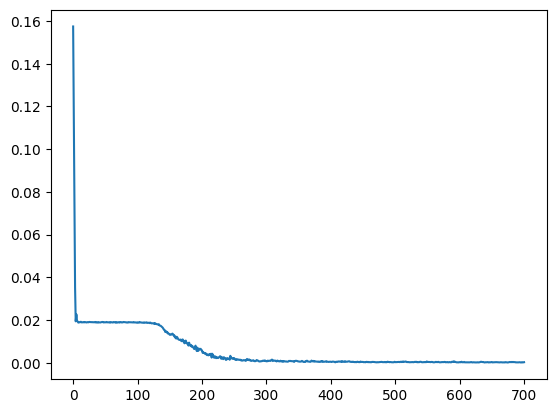

In [13]:
plt.plot(loss_list)

In [14]:
label_y, predicted = predict_mto(model, df, x_ss, y_ms)

16.032585501670837


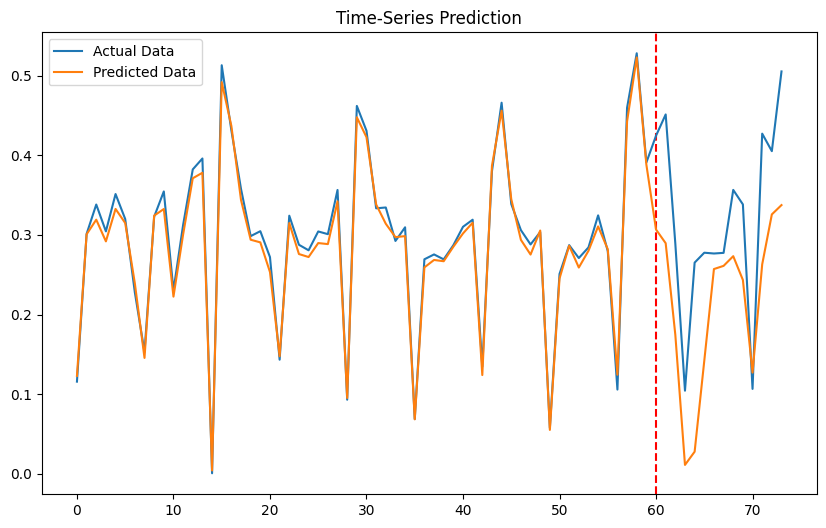

In [8]:
print(mape(label_y, predicted))
plotting(label_y, predicted, 60)

In [11]:
data_predicted = data[['stdDay']].copy()
data_predicted['predicted_alpha'] = 0
data_predicted.iloc[63:, -1] = predicted
data_predicted['predicted_22D'] = data['22D_Infected']
for i in range(123, len(data_predicted)):
    data_predicted.iloc[i, -1] = (data_predicted.iloc[i-1, -1]
                                  *(1-data.iloc[i-1, 6]-data.iloc[i-1, 7]
                                    +(data_predicted.iloc[i-1, 1]*data.iloc[i-1, 1]
                                      /dic_SIRs['대구'].iloc[0, 2])))
data_predicted

,stdDay,predicted_alpha,predicted_22D
0,2022-12-19,0.000000,467.040000
1,2022-12-20,0.000000,2207.040000
2,2022-12-21,0.000000,3942.720000
3,2022-12-22,0.000000,5477.280000
4,2022-12-23,0.000000,6752.640000
...,...,...,...
132,2023-04-30,0.243454,324.092305
133,2023-05-01,0.127110,337.606983
134,2023-05-02,0.263024,300.493162
135,2023-05-03,0.325739,286.027787


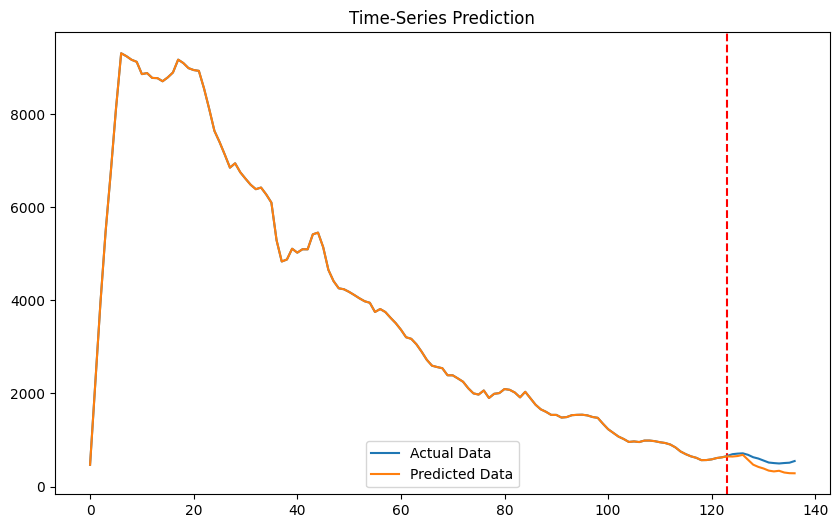

In [12]:
plotting(data['22D_Infected'], data_predicted['predicted_22D'], 123)